In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
import re
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,roc_curve,confusion_matrix
import ast

RANDOM_STATE = 4222

In [32]:
EMBEDDING_FILE = "glove.42B.300d.txt"
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index_profiles = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [33]:
numdim = embeddings_index_profiles[next(iter(embeddings_index_profiles))].shape[0]

In [34]:
dftrain = pd.read_csv('datasets/train.csv')
dftest = pd.read_csv("datasets/test.csv")

In [35]:
dftrain.head()

,Unnamed: 0,title,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,special_characters_title,special_characters_company_profile,special_characters_description,special_characters_requirements,special_characters_benefits,title_length,company_profile_length,description_length,requirements_length,benefits_length
0,4654,Part Time Creative Project Manager,0,NoSleepForSheep is a Nashville-based creative ...,Are you passionate about making people happy a...,1+ year project management experienceException...,Flexible schedule.Opportunity to work with a s...,0,1,1,...,-0.627038,-0.611077,-0.070314,-0.332177,-0.147674,0.389080,-0.549954,0.179512,-0.242055,-0.178123
1,1419,Staffing Support Professional,0,Not specified,Armor People Link is currently seeking a Staff...,"Administrative skills, reception experience, r...",Not specified,0,0,0,...,-0.627038,-0.860832,1.923301,-0.556405,-0.527648,0.028108,-1.076950,2.328606,-0.792097,-0.599683
2,14503,Senior Platform Engineer,0,"Come be a part of one of the fastest growing, ...",As platform software engineer you will contrib...,ResponsibilitiesOwn product features and deliv...,Competitive base salaryStock OptionsFull benef...,0,1,1,...,-0.627038,1.386962,-0.850424,1.517706,0.422287,-0.332863,1.405621,-0.960472,1.372746,0.368343
3,11810,Mechanical Design Engineer - CAD CAE 3D - Balt...,0,We Provide Full Time Permanent Positions for m...,D - 129Experienced Mechanical Design Engineer ...,"Thorough knowledge of machine design, stress a...",Not specified,0,0,0,...,2.118301,-0.486200,-0.243672,0.284451,-0.527648,1.905160,-0.682162,0.436669,0.612444,-0.599683
4,4112,Equipment Operator,0,Not specified,Job OverviewApex is an environmental consultin...,Not specified,Not specified,0,0,1,...,-0.627038,-0.860832,1.706604,-0.780634,-0.527648,-0.693835,-1.076950,2.053081,-0.946849,-0.599683


In [36]:
dftest.head()

,Unnamed: 0,title,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,special_characters_title,special_characters_company_profile,special_characters_description,special_characters_requirements,special_characters_benefits,title_length,company_profile_length,description_length,requirements_length,benefits_length
0,10587,Corporate Travel Counselor On-Site,0,Christopherson Business Travel is the independ...,Full-time Corporate Travel Counselor needed to...,"Proficient GDS skills, Worldspan preferredPref...",Christopherson Business Travel Benefits Portfo...,0,1,1,...,0.288079,0.229223,-1.212085,-0.655492,0.397140,0.408225,-0.109195,-1.330159,-0.568358,0.617015
1,10611,IT Recruiter,0,PROSULTINGISPEOPLEThe ProSulting difference is...,Our client a world leader in employment servic...,"Qualifications: Brings a can do attitude, will...",My client offers all of the advantages you wou...,0,1,1,...,-0.618762,1.181382,-0.817437,-0.295400,0.397140,-1.113320,1.398700,0.012037,-0.525279,0.223574
2,14868,Application Software Engineer,0,"Working at FBNAt FBN, we put farmers first. Fo...",FBN's primary mission is to provide farmers wi...,"ResponsibilitiesOnce you join our team, you wi...",Health insuranceStock optionsFarm visits!,0,1,0,...,-0.618762,1.861495,-0.768106,1.084953,-0.440153,0.045953,3.345823,-0.693719,0.677734,-0.526132
3,15868,Release Manager,0,"ForeFront (Fair Haven, NJ) is a fast-growing b...",RESPONSIBILITIES:The Release Manager will work...,REQUIREMENTS:Extremely detail oriented persona...,"WHY FOREFRONT?Talented, innovative, diverse, a...",0,1,0,...,-0.618762,0.455928,-0.422789,-0.535461,1.420497,-0.968411,0.347324,0.545134,0.427239,0.799794
4,10230,Communications Manager,0,and Aptitude Staffing Solutions have partnere...,Qualified candidates are encouraged to apply d...,Some of the desired skills and experience for ...,Our core values drive our culture. This is wha...,0,1,0,...,-0.618762,-0.405549,0.909146,0.484800,4.862699,-0.388775,-0.200845,1.410945,0.144834,5.006821


In [37]:
df_train = dftrain.drop(dftrain.columns[0],axis=1)
df_test = dftest.drop(dftest.columns[0],axis=1)

In [38]:
smote = SMOTE(random_state=RANDOM_STATE)
x_df_train = df_train.drop(['fraudulent','title','company_profile','description','requirements','benefits','title_tokens','company_profile_tokens','description_tokens','requirements_tokens','benefits_tokens'],axis=1)
y_df_train = df_train['fraudulent']

X_df_resampled,Y_resampled = smote.fit_resample(x_df_train,y_df_train)


In [39]:
def getcosinesimilaritytrain(column):
    job_descriptions_all = df_train[column].apply(ast.literal_eval).apply(lambda x: ' '.join(x)).values
    job_embeddings_all = np.zeros((len(job_descriptions_all), numdim))
    for i, description in enumerate(job_descriptions_all):
        words = description.split()
        embeddings = [embeddings_index_profiles.get(word, np.zeros(numdim)) for word in words]
        if len(words) == 0:
            job_embeddings_all[i] = np.zeros(numdim)
        else:
            job_embeddings_all[i] = np.mean(embeddings, axis=0)
    
    #PERFORM SMOTE
    column_resampled,Y_resampled = smote.fit_resample(job_embeddings_all,y_df_train)
    job_embeddings_fraud = column_resampled[Y_resampled == 1]      
    cos_sim_matrix = cosine_similarity(column_resampled,job_embeddings_fraud)
    cos_sim_highest = []
    for i in range(cos_sim_matrix.shape[0]):
        #return the second highest and not max because returning max would be info leakage (as max cosine-similarity will definitely be 1, which is the job posting itself)
        cos_sim_highest.append(np.sort(cos_sim_matrix[i])[-2])
    return cos_sim_highest

def getcosinesimilaritytest(column):
    job_descriptions_all = df_test[column].apply(ast.literal_eval).apply(lambda x: ' '.join(x)).values
    job_embeddings_all = np.zeros((len(job_descriptions_all), numdim))
    for i, description in enumerate(job_descriptions_all):
        words = description.split()
        embeddings = [embeddings_index_profiles.get(word, np.zeros(numdim)) for word in words]
        if len(words) == 0:
            job_embeddings_all[i] = np.zeros(numdim)
        else:
            job_embeddings_all[i] = np.mean(embeddings, axis=0)

    job_embeddings_fraud = job_embeddings_all[df_test['fraudulent'] == 1] 
    cos_sim_matrix = cosine_similarity(job_embeddings_all,job_embeddings_fraud)
    cos_sim_highest = []
    for i in range(cos_sim_matrix.shape[0]):
        #return the second highest and not max because returning max would be info leakage (as max cosine-similarity will definitely be 1, which is the job posting itself)
        cos_sim_highest.append(np.sort(cos_sim_matrix[i])[-2])
    return cos_sim_highest

def process(column,newcolumn):
    train_cosine_similarity = getcosinesimilaritytrain(column)
    X_df_resampled[newcolumn] = train_cosine_similarity
    test_cosine_similarity = getcosinesimilaritytest(column)
    df_test[newcolumn] = test_cosine_similarity

In [40]:
process('title_tokens','cosine_similarity_title')

In [41]:
process('company_profile_tokens','cosine_similarity_companyprofile')

In [42]:
process('description_tokens','cosine_similarity_description')

In [43]:
process('requirements_tokens','cosine_similarity_requirements')

In [44]:
process('benefits_tokens','cosine_similarity_benefits')

In [45]:
x_df_test = df_test.drop(['fraudulent','title','company_profile','description','requirements','benefits','title_tokens','company_profile_tokens','description_tokens','requirements_tokens','benefits_tokens'],axis=1)
y_df_test = df_test['fraudulent']

In [46]:
params_xgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

model_xgb = XGBClassifier()
grid_search_xgb = GridSearchCV(model_xgb, param_grid=params_xgb, cv=5,n_jobs=-1)
grid_search_xgb.fit(X_df_resampled, Y_resampled)

best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(x_df_test)

In [47]:
def get_confusion_matrix(actual, predicted, title):
    cf = metrics.confusion_matrix(actual, predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive'] 
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()] 

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    s = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', xticklabels=['non fraud', 'fraud'], yticklabels=['non fraud', 'fraud'])
    s.set(xlabel='Predictions', ylabel='True Labels', title=title)
    return s

<AxesSubplot: title={'center': 'XGBoost'}, xlabel='Predictions', ylabel='True Labels'>

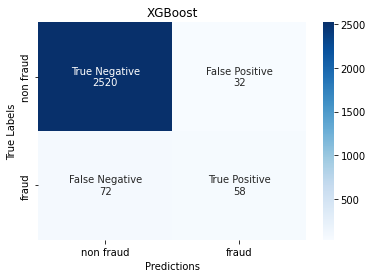

In [48]:
get_confusion_matrix(y_df_test, y_pred_xgb, "XGBoost")

In [49]:
d_xgb = {
    'Recall': [metrics.recall_score(y_df_test,y_pred_xgb)],
    'Precision': [metrics.precision_score(y_df_test,y_pred_xgb)],
    'F1-Score': [metrics.f1_score(y_df_test,y_pred_xgb)],
    'Accuracy': [metrics.accuracy_score(y_df_test,y_pred_xgb)],
    'ROC AUC': [metrics.roc_auc_score(y_df_test,y_pred_xgb)],
}

df_metrics_xgb = pd.DataFrame(d_xgb)
df_metrics_xgb

,Recall,Precision,F1-Score,Accuracy,ROC AUC
0,0.446154,0.644444,0.527273,0.961223,0.716807
